<a href="https://colab.research.google.com/github/cnhzgb/MachineL/blob/main/VAE_CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from einops import rearrange
import time
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("mps")
print(torch.backends.mps.is_available(), torch.backends.mps.is_built(), device)

/Users/bin.guanb/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


True True mps


In [ ]:
trans = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="/Users/bin.guanb/code/MachineL/dataset/", transform=trans, download=True, train=True) # 6W张图片, 10种分类
loader = DataLoader(dataset, batch_size=100, shuffle=True)
batch_num,(image, label) = next(enumerate(loader))
print(len(dataset.classes), len(dataset), image.shape) # 10; 6W; 100,1,28,28

trans_test = transforms.Compose([transforms.ToTensor()])
dataset_test = datasets.MNIST(root="/Users/bin.guanb/code/MachineL/dataset/", transform=trans_test, download=True, train=False) # 1W张图片
loader_test = DataLoader(dataset_test, batch_size=100, shuffle=True)
print(len(dataset_test))

10 60000 torch.Size([100, 1, 28, 28])
10000


In [ ]:
# https://github.com/SashaMalysheva/Pytorch-VAE/blob/master/model.py
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.encoder = nn.Sequential(
        self.conv(1,8), # ,8,14,14
        self.conv(8,32), # ,32,7,7
        self.conv(32,128) # ,128,
    )
    self.decoder = nn.Sequential(nn.Linear(2,256), nn.ReLU(), nn.Linear(256, 28*28), nn.Sigmoid())

  def conv(self, inC, outC):
    return nn.Sequential(
        nn.Conv2d(inC, outC, kernel_size=4, stride=2, padding=1), # 除2处理
        nn.BatchNorm2d(outC), nn.ReLU()
    )

  def deconv(self, inC, outC):
    return nn.Sequential(
        nn.ConvTranspose2d(inC, outC, kernel_size=4, stride=2, padding=1), # 乘2处理
        nn.BatchNorm2d(outC), nn.ReLU()
    )

  def reparam(self, mean, logvar):
    epsilon = torch.randn_like(mean)
    return mean + epsilon * torch.exp(logvar/2)

  def kl_loss(self, mean, logvar):
    return ((mean**2 + logvar.exp() - 1 - logvar) / 2).mean()

  def gen_loss(self, gen_img, img):
    return nn.BCELoss(size_average=False)(gen_img, img) / img.size(0)

  def forward(self, x):
    x = x.view(x.shape[0], -1) # ,28*28
    h = self.encoder(x) # ,2*2
    mean, logvar = h.chunk(2, dim=1) # ,2  + ,2
    h = self.reparam(mean, logvar) #,2
    out = self.decoder(h)
    out = rearrange(out, 'b (h w) -> b 1 h w', h=28)
    return out, mean, logvar

model = Net().to(device)
#print(model)
model_cpu = Net().to("cpu")
#summary(model_cpu, (28,28))

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

epoch:1 batch:599 loss:796.15 mean:1319.38 time:5.2


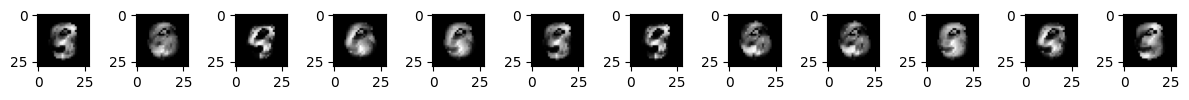

epoch:2 batch:599 loss:552.30 mean:658.41 time:5.1


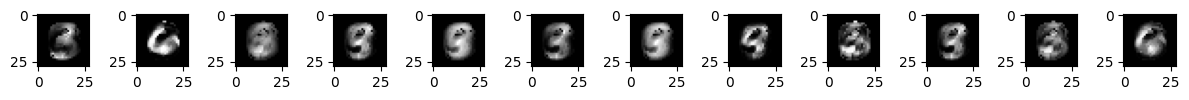

epoch:3 batch:599 loss:376.33 mean:464.36 time:5.1


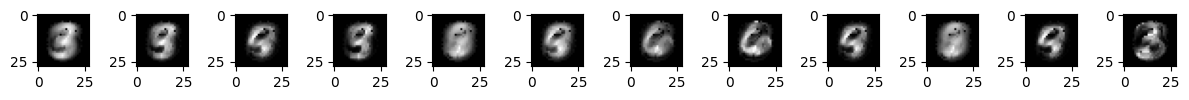

epoch:4 batch:599 loss:367.34 mean:373.77 time:5.3


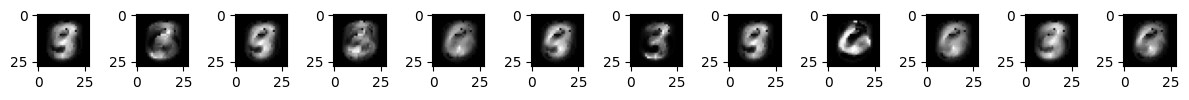

epoch:5 batch:599 loss:312.75 mean:328.74 time:5.2


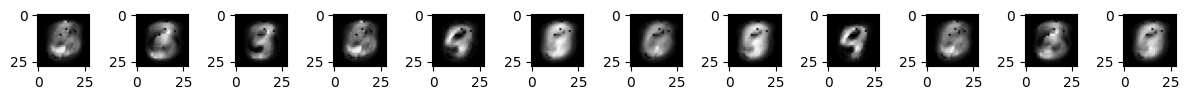

epoch:6 batch:599 loss:284.24 mean:302.66 time:5.2


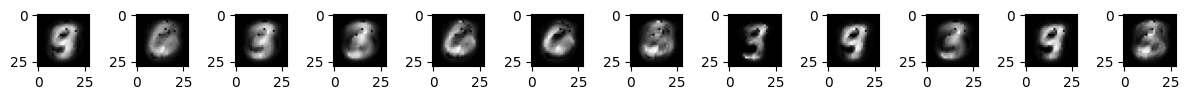

epoch:7 batch:599 loss:257.06 mean:287.47 time:5.2


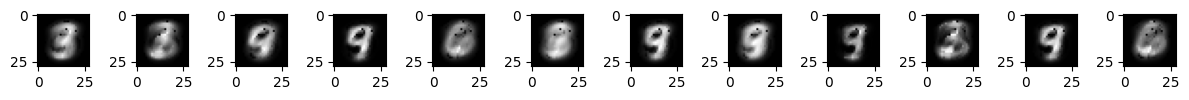

epoch:8 batch:599 loss:290.75 mean:277.67 time:5.1


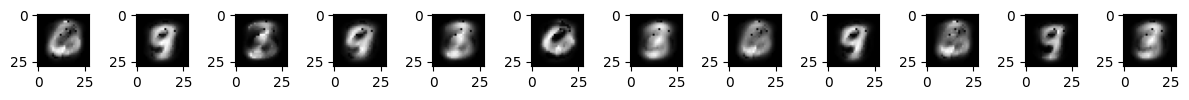

epoch:9 batch:599 loss:260.17 mean:269.84 time:5.2


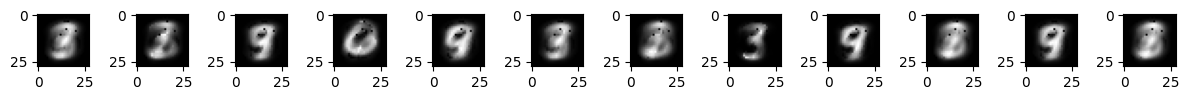

epoch:10 batch:599 loss:254.41 mean:250.83 time:5.2


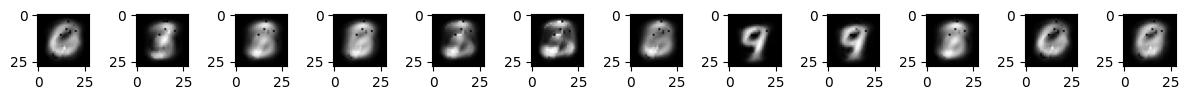

epoch:11 batch:599 loss:224.98 mean:238.97 time:5.3


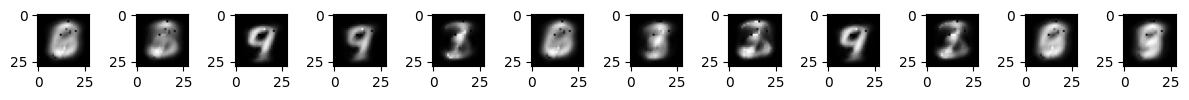

epoch:12 batch:599 loss:227.69 mean:234.75 time:5.2


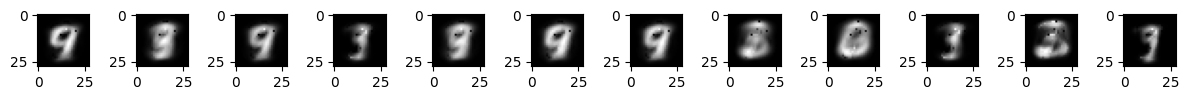

epoch:13 batch:599 loss:227.25 mean:231.57 time:5.2


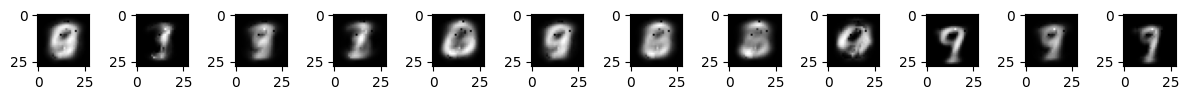

epoch:14 batch:599 loss:217.73 mean:228.99 time:5.1


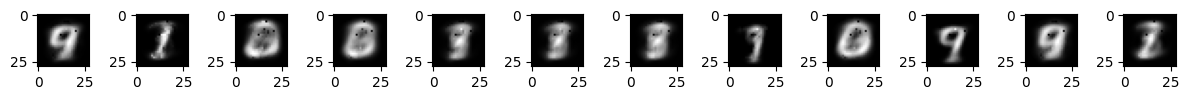

epoch:15 batch:599 loss:224.44 mean:227.03 time:5.1


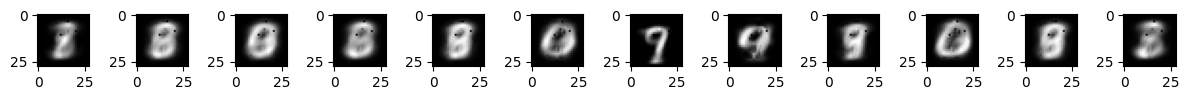

epoch:16 batch:599 loss:214.92 mean:225.58 time:5.1


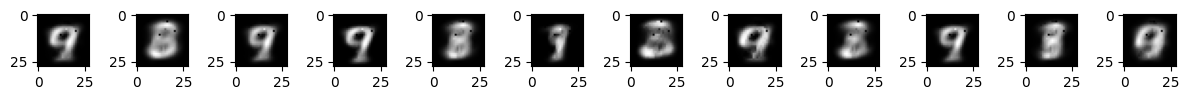

epoch:17 batch:599 loss:226.08 mean:224.31 time:5.1


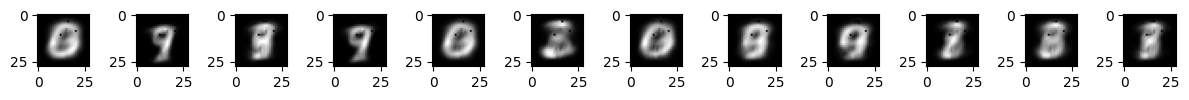

epoch:18 batch:599 loss:221.54 mean:223.23 time:5.1


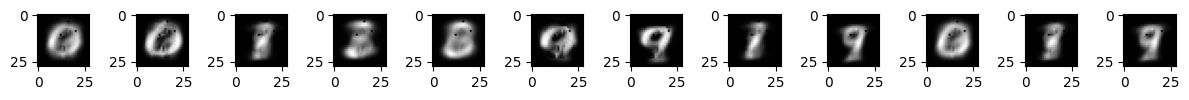

epoch:19 batch:599 loss:209.74 mean:222.26 time:5.1


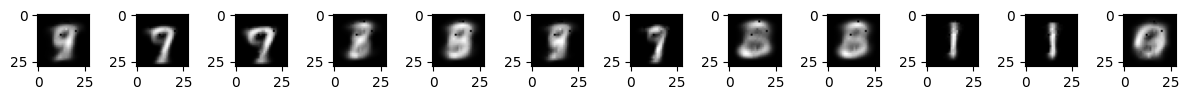

epoch:20 batch:599 loss:217.84 mean:221.32 time:5.2


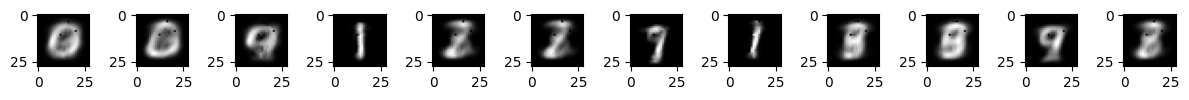

epoch:21 batch:599 loss:222.13 mean:220.44 time:5.2


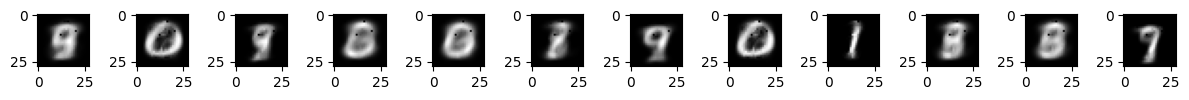

epoch:22 batch:599 loss:231.63 mean:219.53 time:5.1


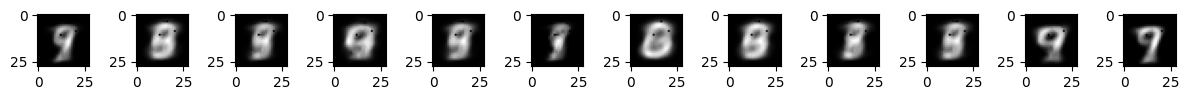

epoch:23 batch:599 loss:220.84 mean:218.63 time:5.1


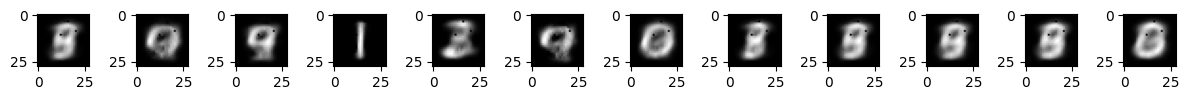

epoch:24 batch:599 loss:214.30 mean:217.52 time:5.1


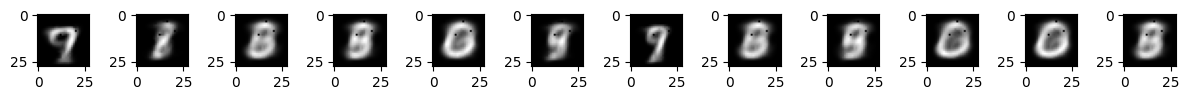

epoch:25 batch:599 loss:209.36 mean:211.54 time:5.1


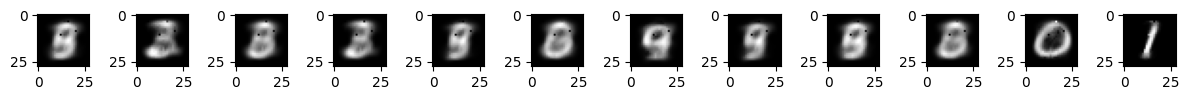

epoch:26 batch:599 loss:200.15 mean:208.94 time:5.1


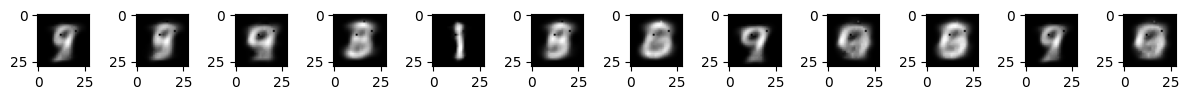

epoch:27 batch:599 loss:217.47 mean:208.19 time:5.1


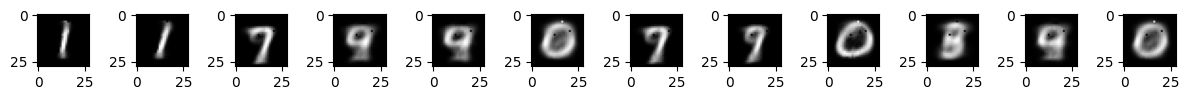

epoch:28 batch:599 loss:206.93 mean:207.44 time:5.1


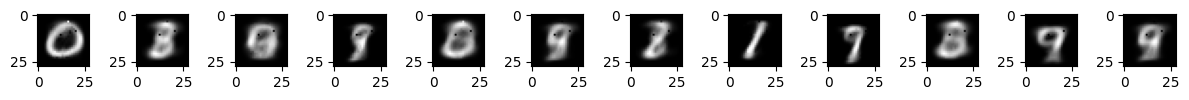

epoch:29 batch:599 loss:208.42 mean:206.78 time:5.1


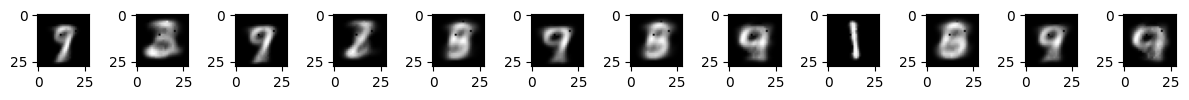

epoch:30 batch:599 loss:206.70 mean:206.06 time:5.1


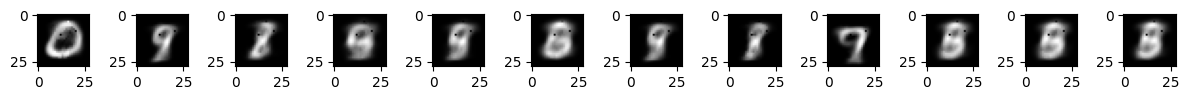

epoch:31 batch:599 loss:201.98 mean:205.47 time:5.1


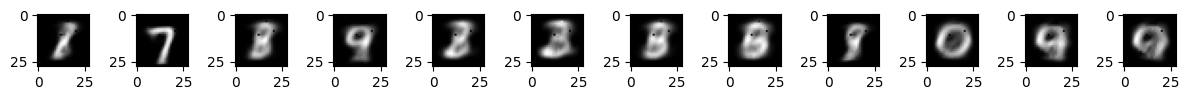

epoch:32 batch:599 loss:196.53 mean:204.89 time:5.1


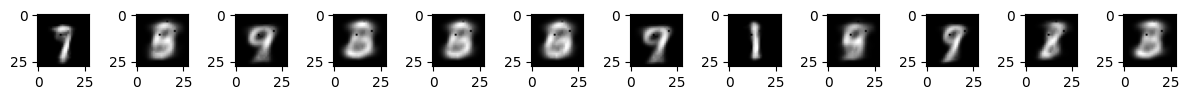

epoch:33 batch:599 loss:208.68 mean:204.30 time:5.1


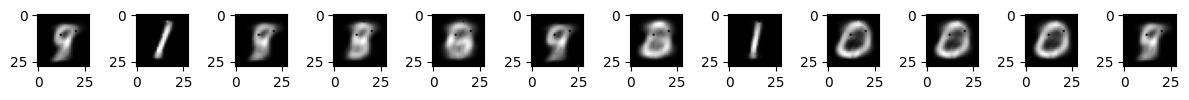

epoch:34 batch:599 loss:214.66 mean:203.54 time:5.1


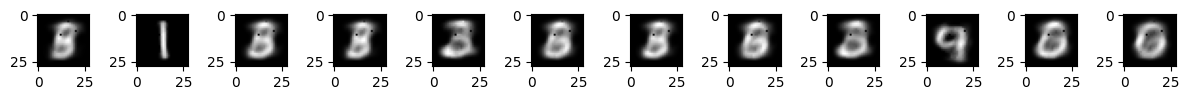

epoch:35 batch:599 loss:187.23 mean:199.99 time:5.1


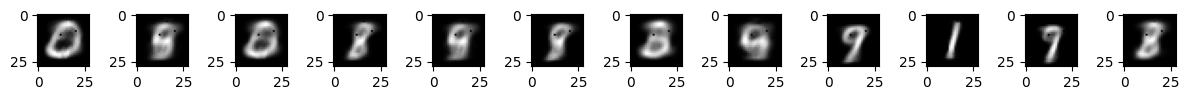

epoch:36 batch:599 loss:200.42 mean:188.99 time:5.1


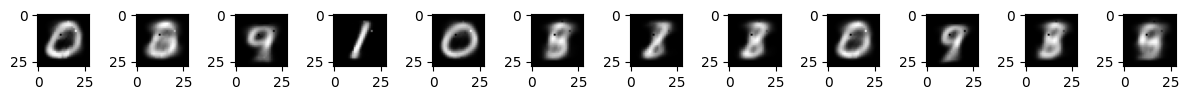

epoch:37 batch:599 loss:184.49 mean:187.23 time:5.1


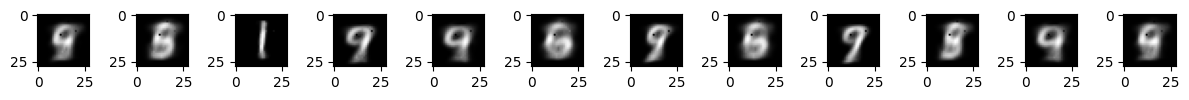

epoch:38 batch:599 loss:195.34 mean:186.75 time:5.1


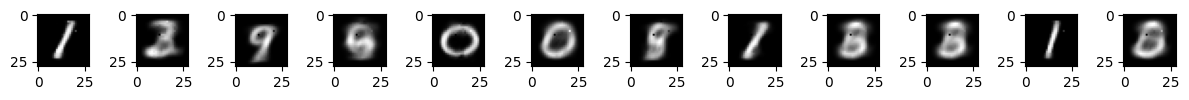

epoch:39 batch:599 loss:187.41 mean:186.29 time:5.2


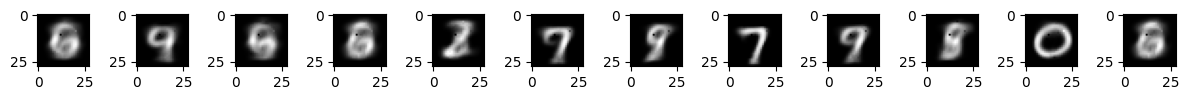

epoch:40 batch:599 loss:185.56 mean:185.93 time:5.3


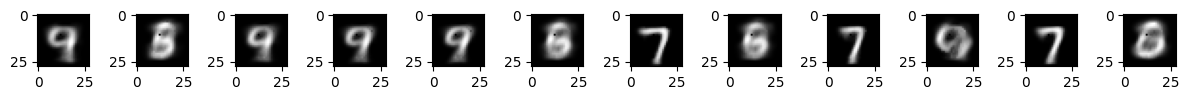

epoch:41 batch:599 loss:187.64 mean:185.54 time:5.2


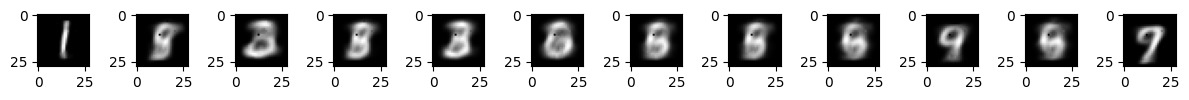

epoch:42 batch:599 loss:181.13 mean:185.21 time:5.3


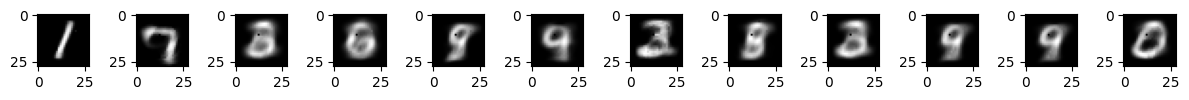

epoch:43 batch:599 loss:188.66 mean:184.88 time:5.1


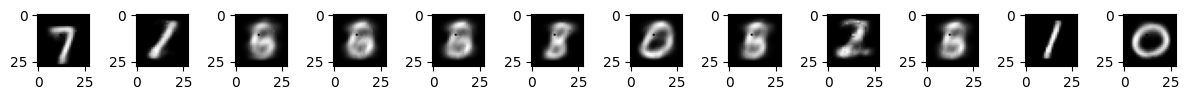

epoch:44 batch:599 loss:194.90 mean:184.54 time:5.3


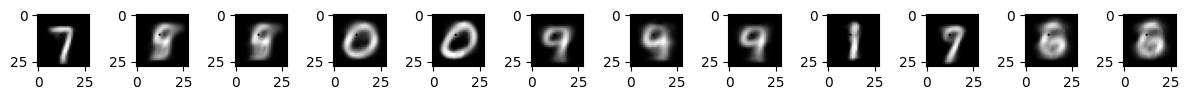

epoch:45 batch:599 loss:178.14 mean:184.22 time:5.3


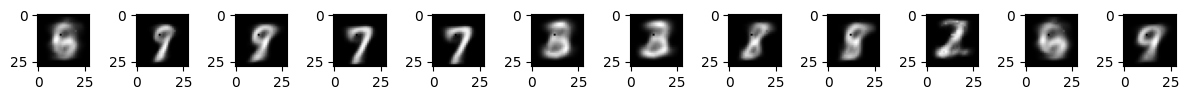

epoch:46 batch:599 loss:185.49 mean:183.90 time:5.3


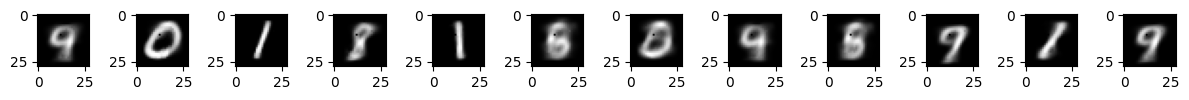

epoch:47 batch:599 loss:196.17 mean:183.52 time:5.5


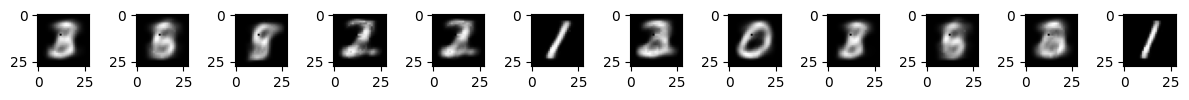

epoch:48 batch:599 loss:180.62 mean:183.08 time:5.1


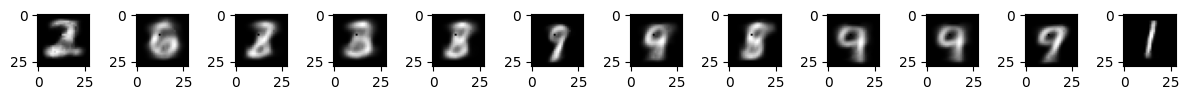

epoch:49 batch:599 loss:165.42 mean:182.36 time:5.2


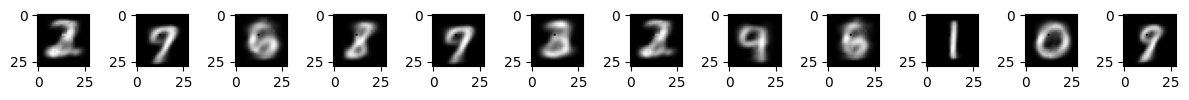

epoch:50 batch:599 loss:171.82 mean:178.63 time:5.1


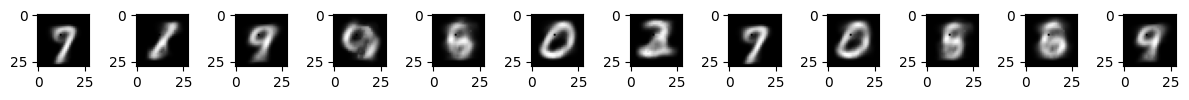

epoch:51 batch:599 loss:171.26 mean:167.55 time:5.2


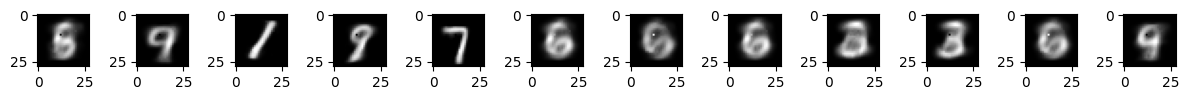

epoch:52 batch:599 loss:162.20 mean:164.20 time:5.2


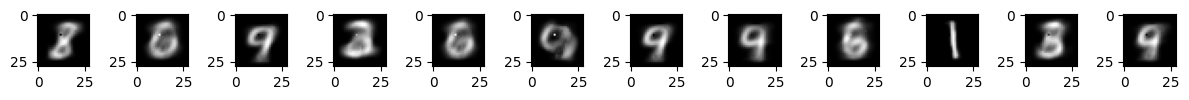

epoch:53 batch:599 loss:159.14 mean:163.36 time:5.2


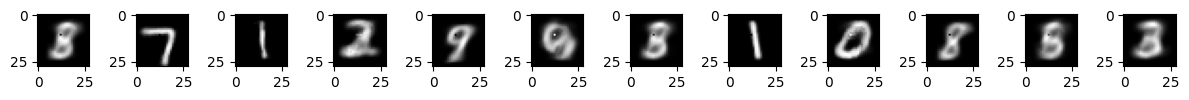

epoch:54 batch:599 loss:172.15 mean:162.66 time:5.2


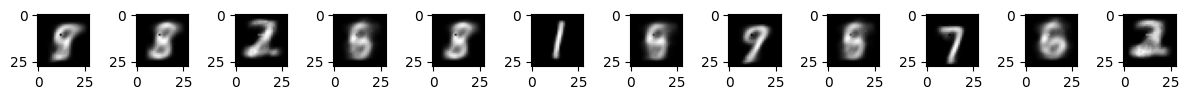

epoch:55 batch:599 loss:155.53 mean:162.03 time:5.3


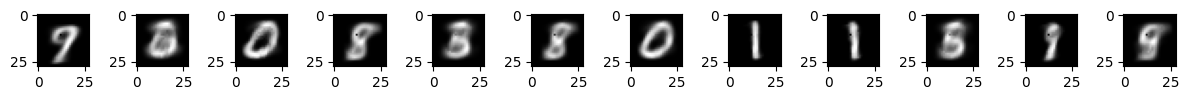

epoch:56 batch:599 loss:162.52 mean:161.58 time:5.1


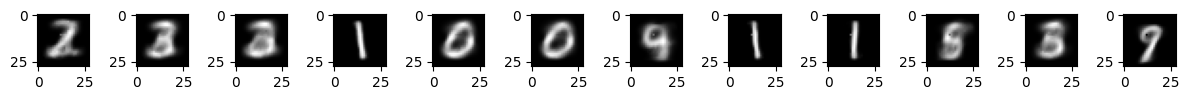

epoch:57 batch:599 loss:156.61 mean:161.23 time:5.1


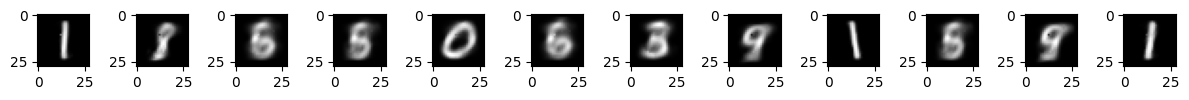

epoch:58 batch:599 loss:161.24 mean:160.99 time:5.1


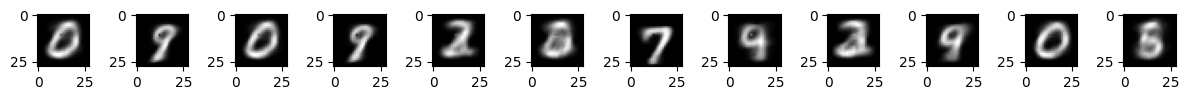

epoch:59 batch:599 loss:157.41 mean:160.73 time:5.4


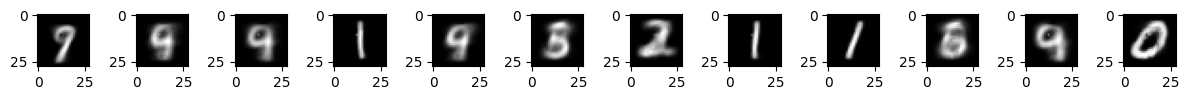

epoch:60 batch:599 loss:155.87 mean:160.51 time:5.1


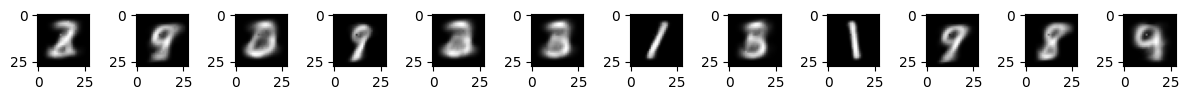

epoch:61 batch:599 loss:155.36 mean:160.25 time:5.2


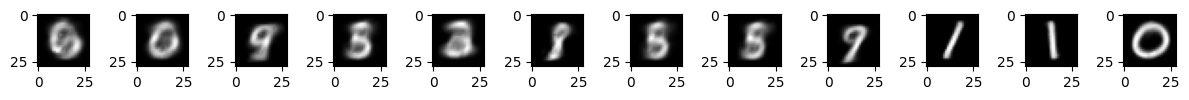

epoch:62 batch:599 loss:160.97 mean:160.07 time:5.3


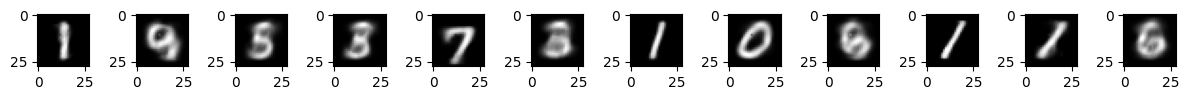

epoch:63 batch:599 loss:155.19 mean:159.83 time:5.2


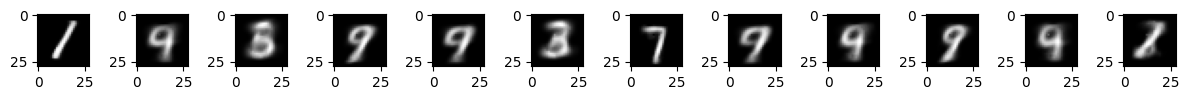

epoch:64 batch:599 loss:161.18 mean:159.62 time:5.6


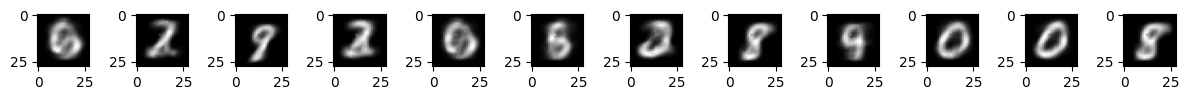

epoch:65 batch:599 loss:164.03 mean:159.43 time:5.7


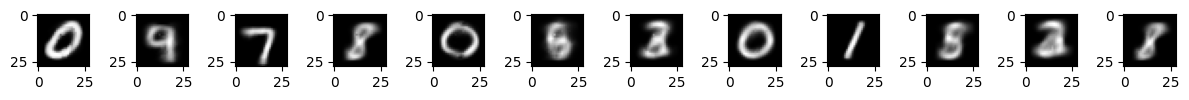

epoch:66 batch:599 loss:167.68 mean:159.21 time:5.3


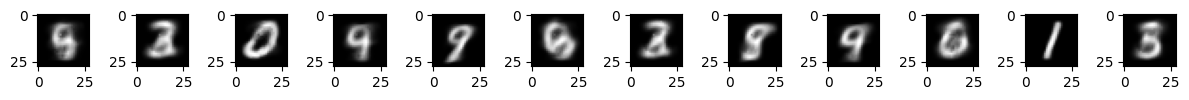

epoch:67 batch:599 loss:156.67 mean:158.98 time:5.3


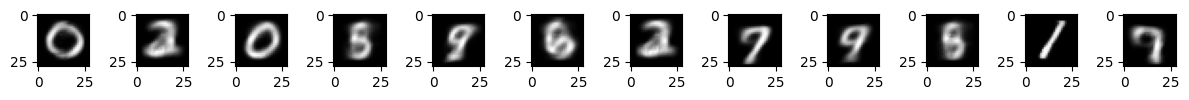

epoch:68 batch:599 loss:161.16 mean:158.81 time:5.2


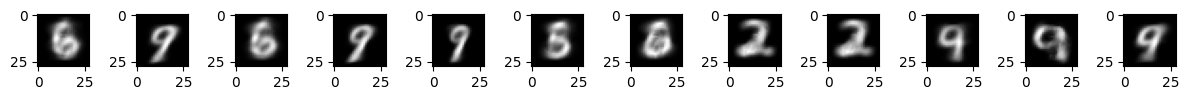

epoch:69 batch:599 loss:150.29 mean:158.64 time:5.2


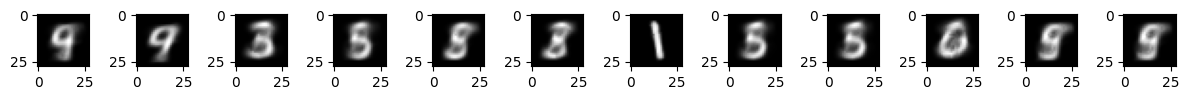

epoch:70 batch:599 loss:162.23 mean:158.45 time:5.3


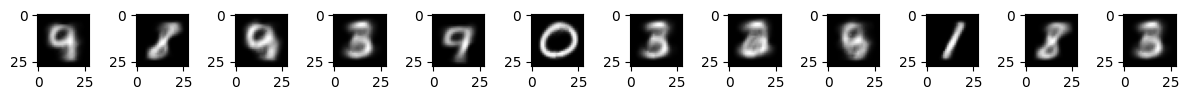

epoch:71 batch:599 loss:165.62 mean:158.26 time:5.3


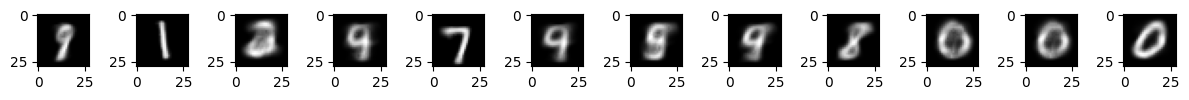

epoch:72 batch:599 loss:162.06 mean:158.07 time:5.2


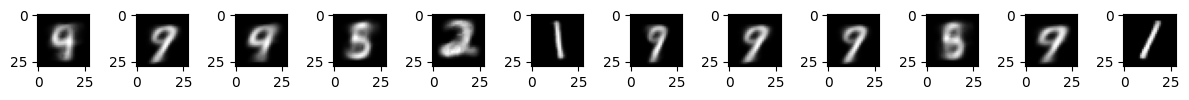

epoch:73 batch:599 loss:142.19 mean:157.89 time:5.3


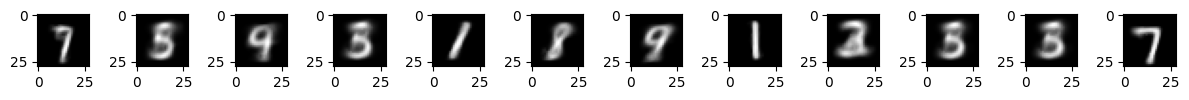

epoch:74 batch:599 loss:166.83 mean:157.75 time:5.3


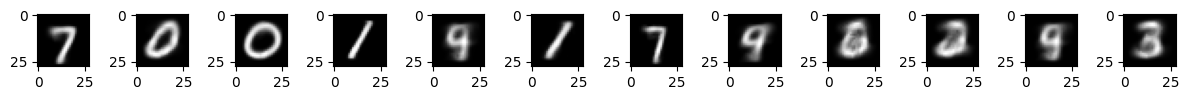

epoch:75 batch:599 loss:161.76 mean:157.56 time:5.2


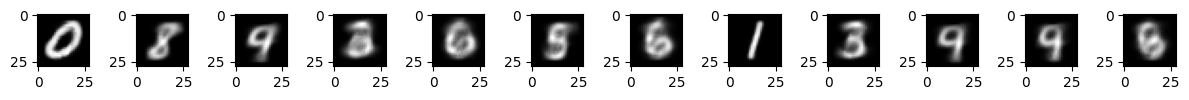

epoch:76 batch:599 loss:161.75 mean:157.41 time:5.2


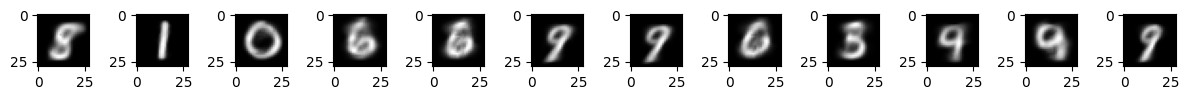

epoch:77 batch:599 loss:157.76 mean:157.23 time:5.3


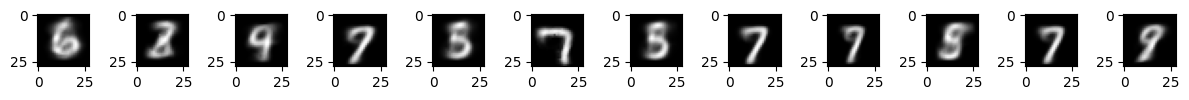

epoch:78 batch:599 loss:157.52 mean:157.09 time:5.2


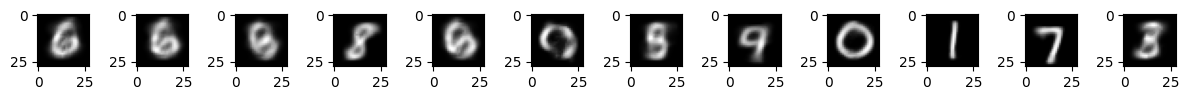

epoch:79 batch:599 loss:150.42 mean:156.93 time:5.5


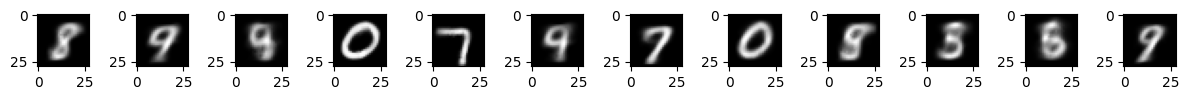

epoch:80 batch:599 loss:151.12 mean:156.79 time:5.2


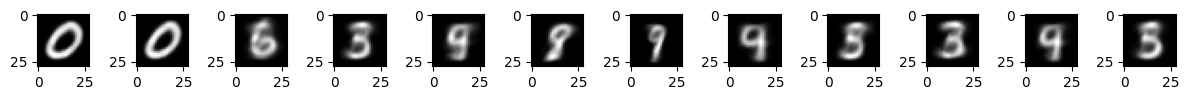

epoch:81 batch:599 loss:155.34 mean:156.65 time:5.2


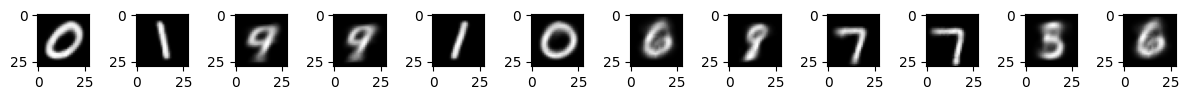

epoch:82 batch:599 loss:147.95 mean:156.52 time:5.1


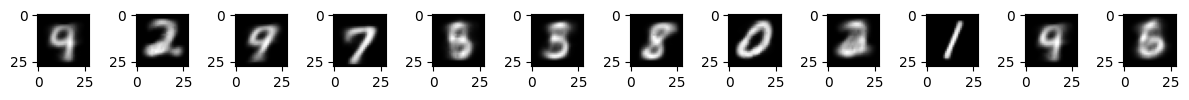

epoch:83 batch:599 loss:161.95 mean:156.35 time:5.3


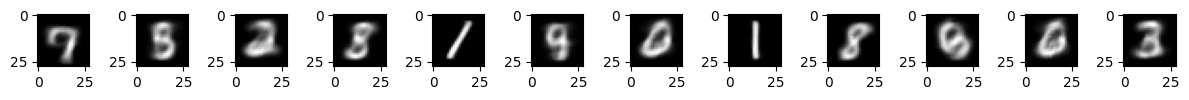

epoch:84 batch:599 loss:153.07 mean:156.21 time:5.4


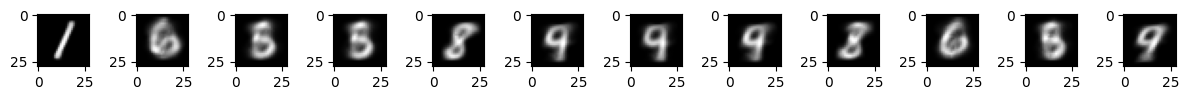

epoch:85 batch:599 loss:153.85 mean:156.07 time:5.2


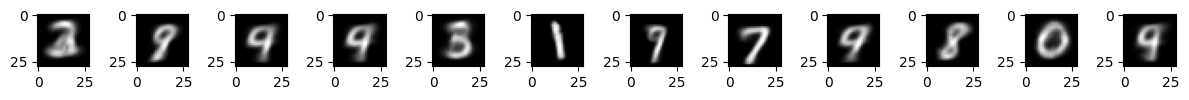

epoch:86 batch:599 loss:149.15 mean:155.96 time:5.1


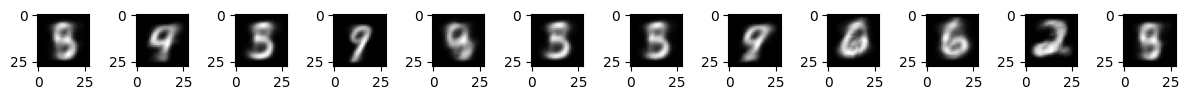

epoch:87 batch:599 loss:158.51 mean:155.81 time:5.1


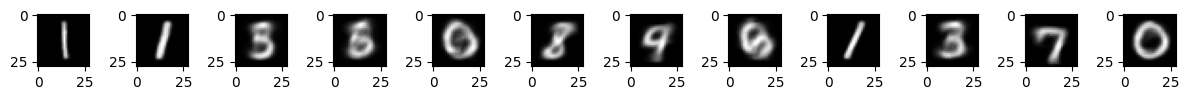

epoch:88 batch:599 loss:159.09 mean:155.68 time:5.1


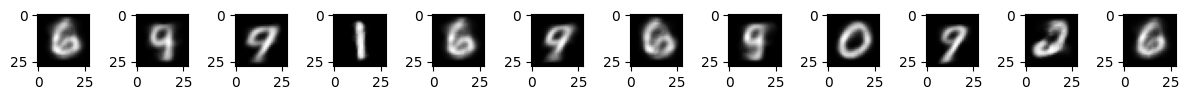

epoch:89 batch:599 loss:160.74 mean:155.59 time:5.1


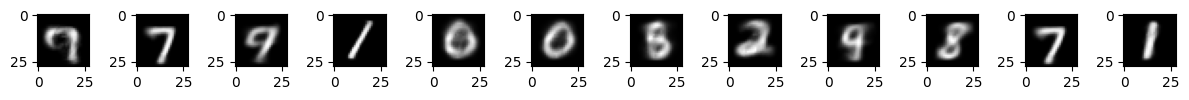

epoch:90 batch:599 loss:151.13 mean:155.45 time:5.1


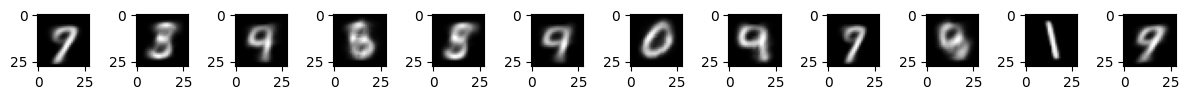

epoch:91 batch:599 loss:158.47 mean:155.29 time:5.1


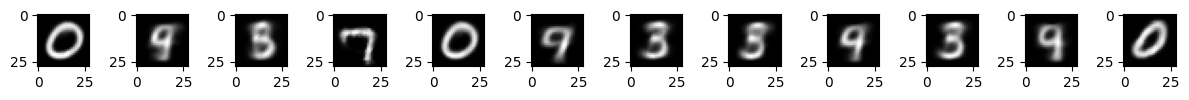

epoch:92 batch:599 loss:157.29 mean:155.17 time:5.2


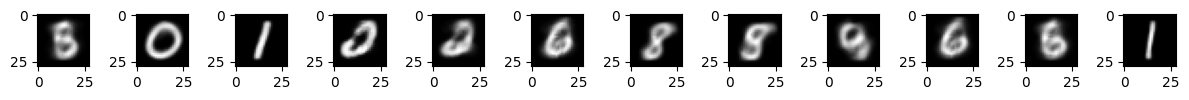

epoch:93 batch:599 loss:157.86 mean:155.05 time:5.2


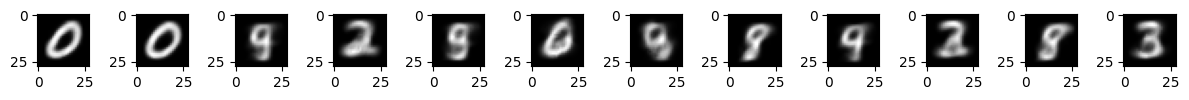

epoch:94 batch:599 loss:151.55 mean:154.93 time:5.3


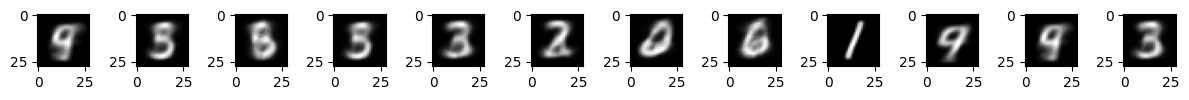

epoch:95 batch:599 loss:159.31 mean:154.83 time:5.5


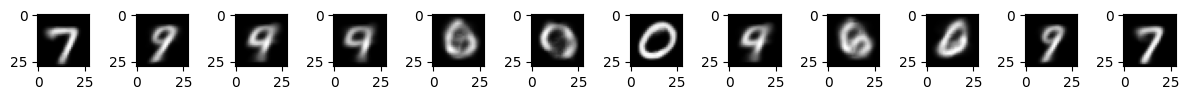

epoch:96 batch:599 loss:156.08 mean:154.70 time:5.2


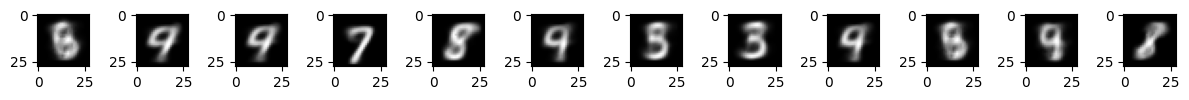

epoch:97 batch:599 loss:152.45 mean:154.61 time:5.1


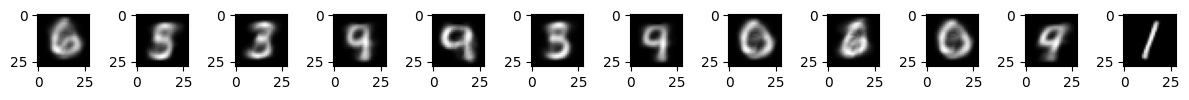

epoch:98 batch:599 loss:156.52 mean:154.51 time:5.2


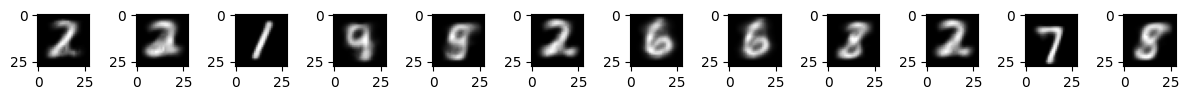

epoch:99 batch:599 loss:147.72 mean:154.38 time:5.2


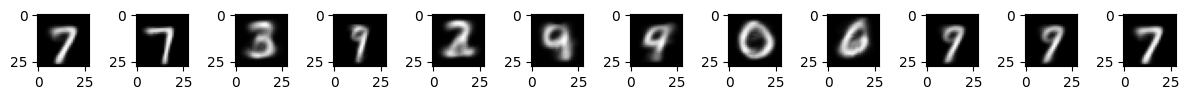

In [ ]:
for epoch in range(1,100):
  total_loss = []
  startTime = time.time()
  for batch_idx, (img, label) in enumerate(loader):
    img = img.to(device)
    label = label.to(device)
    gen_img, mean, logvar = model(img)

    loss = model.gen_loss(gen_img, img) + model.kl_loss(mean, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss.append(loss.item())

    if(batch_idx == 599):
      print("epoch:{} batch:{} loss:{:.2f} mean:{:.2f} time:{:.1f}".format(
          epoch, batch_idx, loss, np.mean(total_loss), time.time()-startTime))
      with torch.no_grad():
        fig, axs = plt.subplots(1, 12, figsize=(12, 1))
        for i, ax in enumerate(axs.flatten()):
          ax.imshow(gen_img[i][0].cpu(), cmap='gray')
        plt.tight_layout()
        plt.show()

      startTime = time.time()

In [ ]:
plt.plot(total_loss)
plt.title("Learning Curve")
plt.legend();